Write your post here.

The CI algorithm:
$$ CI=Rrs\left(\lambda_{green}\right) - \big[Rrs\left(\lambda_{blue}\right) +\frac{\lambda_{green} - \lambda_{blue}}{\lambda_{red} -\lambda_{blue}} * \big(Rrs\left(\lambda_{red}\right) - Rrs\left(\lambda_{blue}\right)\big)\big]$$

The OCx algorithm:
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\frac{Rrs\left(\lambda_{blue}\right)}{Rrs\left(\lambda_{green}\right)}$$

In [105]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle

In [133]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [22]:
%matplotlib inline

In [4]:
fpath ='/accounts/ekarakoy/DATA/OWT/nomad_rrs4clustering.mat'
matlabData = loadmat(fpath)

In [153]:
pl.rcParams['xtick.labelsize']

16.0

In [154]:
rc={'axes.labelsize': 16, 'font.size': 22, 'legend.fontsize': 12,
    'axes.titlesize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
pl.rcParams.update(**rc)

In [5]:
wavelength = matlabData['wl'][0]
wavelength = matlabData['wl'][0]
rrsBelow = matlabData['rrs_below']
chl = matlabData['chl_nomad'] # I might use this as an additional feature in clustering

In [6]:
labels = list(wavelength) + ['chl']
df = pd.DataFrame(data=np.hstack((rrsBelow, chl)), columns=labels)
df.head()

,411,443,469,489,510,520,547,550,555,560,565,670,chl
0,0.002307,0.003225,0.004674,0.006265,0.007661,0.008944,0.012935,0.013410,0.014040,0.014715,0.015325,0.006588,38.19
1,0.002035,0.002650,0.003273,0.004149,0.004767,0.005416,0.007338,0.007570,0.007878,0.008208,0.008549,0.003241,35.01
2,0.001862,0.002271,0.002654,0.003523,0.004367,0.005147,0.007423,0.007691,0.008053,0.008434,0.008822,0.003084,26.91
3,0.002817,0.003330,0.004096,0.005482,0.006963,0.008243,0.012075,0.012525,0.013127,0.013770,0.014361,0.006154,47.96
4,0.001735,0.001959,0.002129,0.002882,0.003638,0.004115,0.005079,0.005191,0.005337,0.005507,0.005716,0.003423,23.55


Make a new dataframe with just SeaWiFS-wavelength Rrs and chl.

In [7]:
swfWvl = [411, 443, 489, 510, 555, 670]

In [106]:
dfSwf = df.loc[:, swfWvl + ['chl']]
dfSwf['maxBlue'] = dfSwf.loc[:,[443, 490, 510]].max(axis=1)
dfSwf['OCx_ratio'] = dfSwf.maxBlue/dfSwf[555]
dfSwf.head()

,411,443,489,510,555,670,chl,maxBlue,OCx_ratio
0,0.002307,0.003225,0.006265,0.007661,0.014040,0.006588,38.19,0.007661,0.545671
1,0.002035,0.002650,0.004149,0.004767,0.007878,0.003241,35.01,0.004767,0.605151
2,0.001862,0.002271,0.003523,0.004367,0.008053,0.003084,26.91,0.004367,0.542267
3,0.002817,0.003330,0.005482,0.006963,0.013127,0.006154,47.96,0.006963,0.530461
4,0.001735,0.001959,0.002882,0.003638,0.005337,0.003423,23.55,0.003638,0.681603


In [107]:
dfSwf.describe()

,411,443,489,510,555,670,chl,maxBlue,OCx_ratio
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000
mean,0.009913,0.009351,0.009086,0.007638,0.006105,0.001289,1.544312,0.010468,2.534806
std,0.006548,0.005329,0.004598,0.004656,0.006091,0.002629,4.002408,0.005845,1.971354
min,0.000098,0.000365,0.000546,0.000502,0.000398,0.000023,0.000000,0.000502,0.444390
25%,0.005000,0.005335,0.006135,0.005511,0.003029,0.000196,0.054000,0.006135,1.046929
50%,0.007967,0.008120,0.008528,0.006562,0.003970,0.000385,0.301200,0.009098,1.579979
75%,0.013895,0.012699,0.011118,0.007965,0.006047,0.001101,1.218750,0.013822,3.804136
max,0.039485,0.031489,0.046573,0.050136,0.060087,0.031832,72.120000,0.050136,9.949075


In [108]:
dfSwf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2404 entries, 0 to 2403
Data columns (total 9 columns):
411          2404 non-null float64
443          2404 non-null float64
489          2404 non-null float64
510          2404 non-null float64
555          2404 non-null float64
670          2404 non-null float64
chl          2404 non-null float64
maxBlue      2404 non-null float64
OCx_ratio    2404 non-null float64
dtypes: float64(9)
memory usage: 169.1 KB


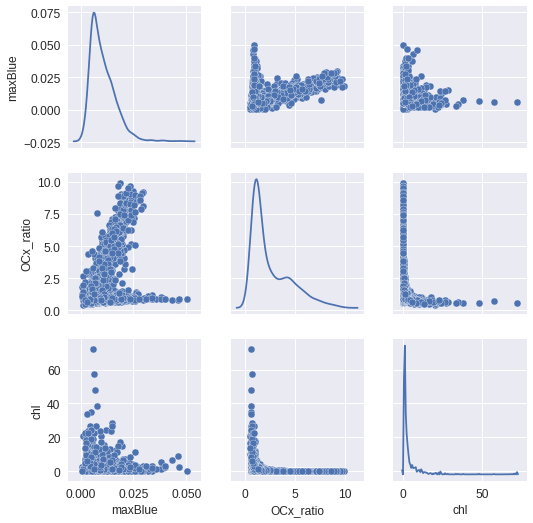

In [110]:
sb.pairplot(dfSwf[['maxBlue','OCx_ratio','chl']],diag_kind='kde');

I'll apply a log transformation here but note that there is a few 0-chlorophyll points. I'm going to first add a very low offset so I can take the log of the cholorophyll here.

In [117]:
dfSwfLog = dfSwf.copy()
dfSwfLog['chl'] += 1e-7
dfSwfLog = dfSwf.apply(np.log10)
dfSwfLog.head()

,411,443,489,510,555,670,chl,maxBlue,OCx_ratio
0,-2.636939,-2.491513,-2.203050,-2.115709,-1.852640,-2.181247,1.581950,-2.115709,-0.263069
1,-2.691502,-2.576822,-2.382034,-2.321729,-2.103593,-2.489264,1.544192,-2.321729,-0.218136
2,-2.730102,-2.643789,-2.453040,-2.359837,-2.094050,-2.510846,1.429914,-2.359837,-0.265787
3,-2.550239,-2.477612,-2.261083,-2.157190,-1.881843,-2.210852,1.680879,-2.157190,-0.275346
4,-2.760594,-2.707861,-2.540331,-2.439165,-2.272697,-2.465559,1.371991,-2.439165,-0.166468


In [118]:
dfSwfLog.describe()

,411,443,489,510,555,670,chl,maxBlue,OCx_ratio
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000
mean,-2.106790,-2.107235,-2.091830,-2.167808,-2.328985,-3.296429,-inf,-2.045267,0.283718
std,0.322269,0.278722,0.216597,0.200705,0.282423,0.545944,NaN,0.245931,0.319583
min,-4.006806,-3.437444,-3.262937,-3.299469,-3.399661,-4.644138,-inf,-3.299469,-0.352235
25%,-2.301007,-2.272877,-2.212160,-2.258763,-2.518654,-3.706764,-1.267606,-2.212158,0.019917
50%,-2.098709,-2.090449,-2.069159,-2.182931,-2.401261,-3.414553,-0.521145,-2.041034,0.198651
75%,-1.857153,-1.896216,-1.953965,-2.098792,-2.218459,-2.958027,0.085911,-1.859430,0.580256
max,-1.403566,-1.501841,-1.331864,-1.299849,-1.221218,-1.497139,1.858056,-1.299849,0.997783


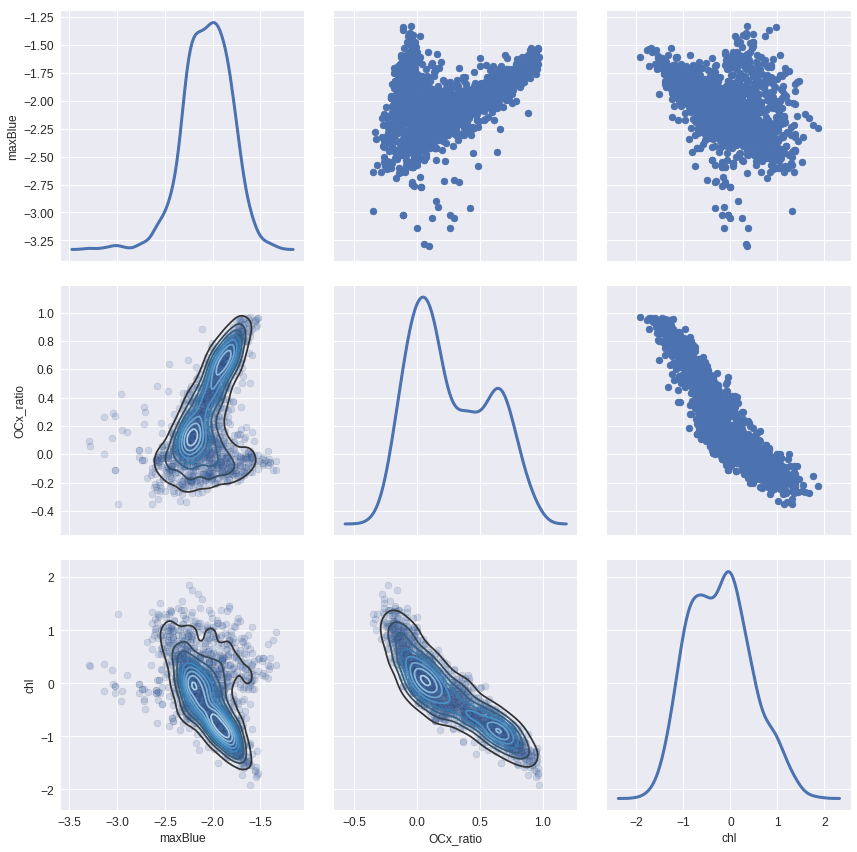

In [131]:
fg = sb.pairplot(dfSwfLog, vars=['maxBlue','OCx_ratio','chl'],
            diag_kind='kde', size=4, plot_kws={'alpha': 0.2,'edgecolor':'k'});
fg = fg.map_upper(pl.scatter)
fg = fg.map_lower(sb.kdeplot, cmap="Blues_d")
fg = fg.map_diag(sb.kdeplot, lw=3)

Note the dispersion of 0 chlorlphyll relative to other bands. This signals a problem with the 0-chlorophyll data and will therefore get dropped. This represents...

In [119]:
dfSwf.loc[dfSwf.chl==0,'chl'].count()/dfSwf.size*100

2.4496210020336475

... < 3% of the data. The rest of the lognormal data appears to be well behaved

In [120]:
dfSwfLog = dfSwfLog.loc[dfSwfLog.chl>-5,:]

The NASA chlorophyll *a* ATBD suggests specifies that 
* for "chlorophyll retrievals below 0.15 mg m-3, the CI algorithm is used".
* For chlorophyll retrievals above 0.2 mg m-3, the OCx algorithm is used.
* In between these values, the CI and OCx algorithm are blended using a weighted approach.

Let's see how many entries we have for each category:

In [121]:
lowChlCount = dfSwfLog.loc[dfSwfLog.chl<np.log10(0.15)].shape[0]

In [122]:
hiChlCount = dfSwfLog.loc[dfSwfLog.chl>np.log10(0.2),:].shape[0]

In [123]:
medChlCount = dfSwfLog.shape[0] - (lowChlCount + hiChlCount)

In [124]:
print("entry number for:")
print("* low count:  %d" % lowChlCount)
print("* imd. count: %d" % medChlCount)
print("* high count: %d" % hiChlCount)

entry number for:
* low count:  387
* imd. count: 116
* high count: 1371


In [132]:
ocxRatio = dfSwfLog.OCx_ratio.values
chlObs = dfSwfLog.chl.values 

In [134]:
with pm.Model() as model_OCx:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * ocxRatio + a2 * ocxRatio**2 + a3 * ocxRatio**3 + a4 * ocxRatio**4
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOCx = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval_ to model.
100%|██████████| 10000/10000 [01:04<00:00, 155.77it/s]


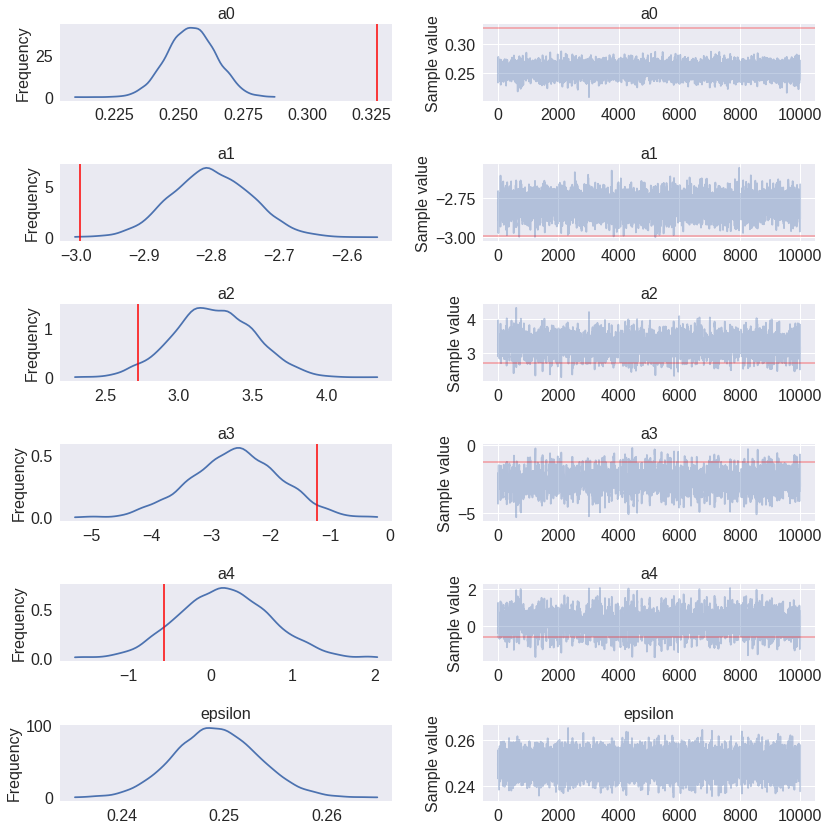

In [172]:
chainOCx = traceOCx[1000:]
varnames=['a%d' %d for d in range(5)]
varnames.append('epsilon')
refvals = {'a%d' %d: rv for d,rv in zip(range(5), nomadSwf) }
pm.traceplot(traceOCx,varnames=varnames,lines=refvals);

In [141]:
pm.df_summary(chainOCx, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a0,0.255015,0.009450,0.000170,0.236689,0.273473
a1,-2.800152,0.059543,0.001080,-2.914079,-2.682124
a2,3.236102,0.273017,0.007060,2.673793,3.743313
a3,-2.580770,0.750446,0.022624,-3.980479,-1.032953
a4,0.164736,0.554472,0.016703,-0.870562,1.261476
epsilon,0.249228,0.004105,0.000039,0.241129,0.257194


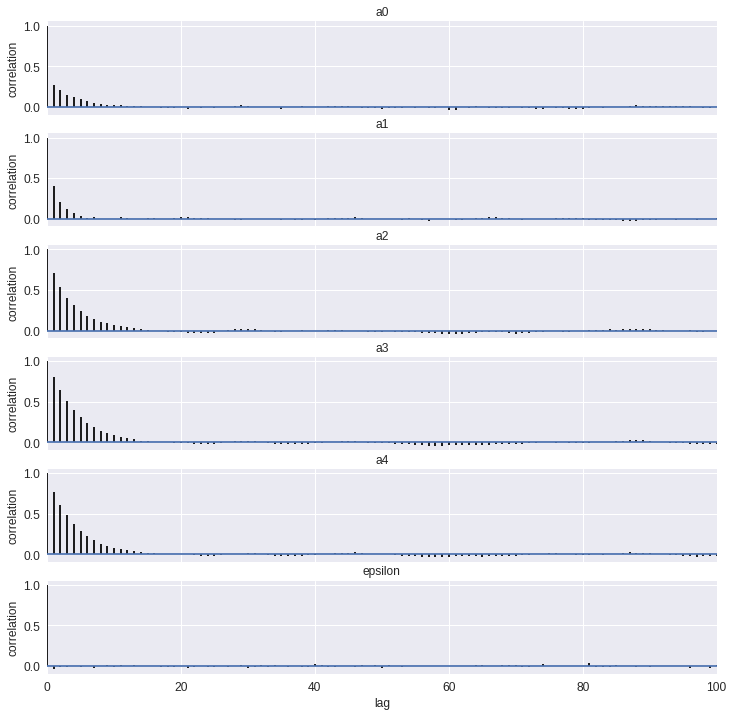

In [143]:
pm.autocorrplot(chainOCx, varnames=varnames);

In [155]:
sb.set(rc=rc)

In [173]:
refVals=[0.3272,-2.9940,2.7218, -1.2259, -0.5683]

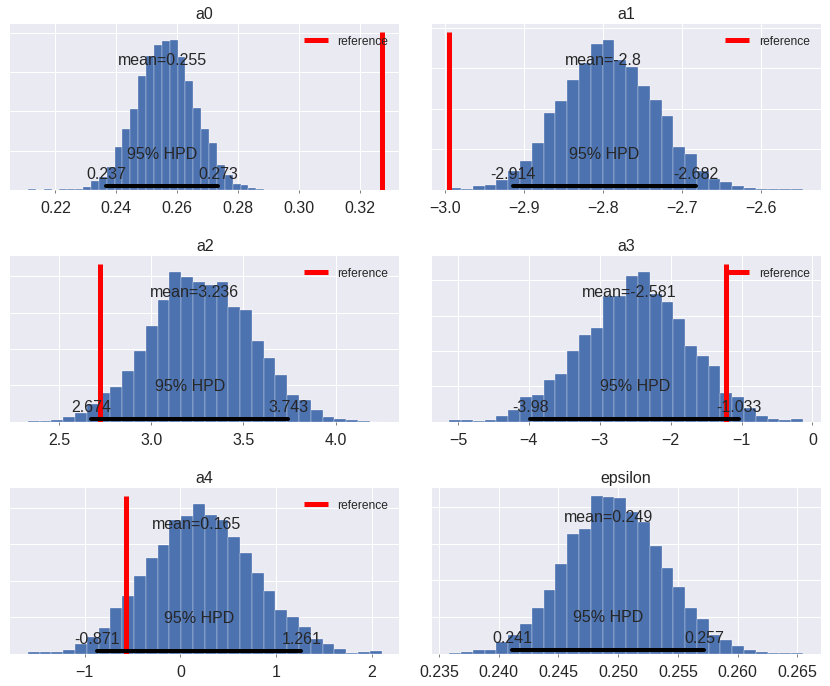

In [178]:
axs=pm.plot_posterior(chainOCx,varnames=varnames, figsize=(12,10))
for ax,rv in zip(axs.ravel(),refVals):
    ax.vlines(rv,0,ax.get_ylim()[1], colors='r', linewidth=5, label='reference')
    ax.legend()

In [194]:
chlModl=0
ocxRatioMock = np.linspace(ocxRatio.min(),ocxRatio.max(),100)
for i in range(5):
    chlModl+= refVals[i]*ocxRatioMock**i

In [197]:
chlBayes=0
for i in range(5):
    chlBayes += chainOCx['a%d' %i].mean()*ocxRatioMock**i

In [209]:
idx = np.argsort(ocxRatio)
ocxRatio_ord = ocxRatio[idx]
ppc = pm.sample_ppc(chainOCx, samples=1000, model=model_OCx)
sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]

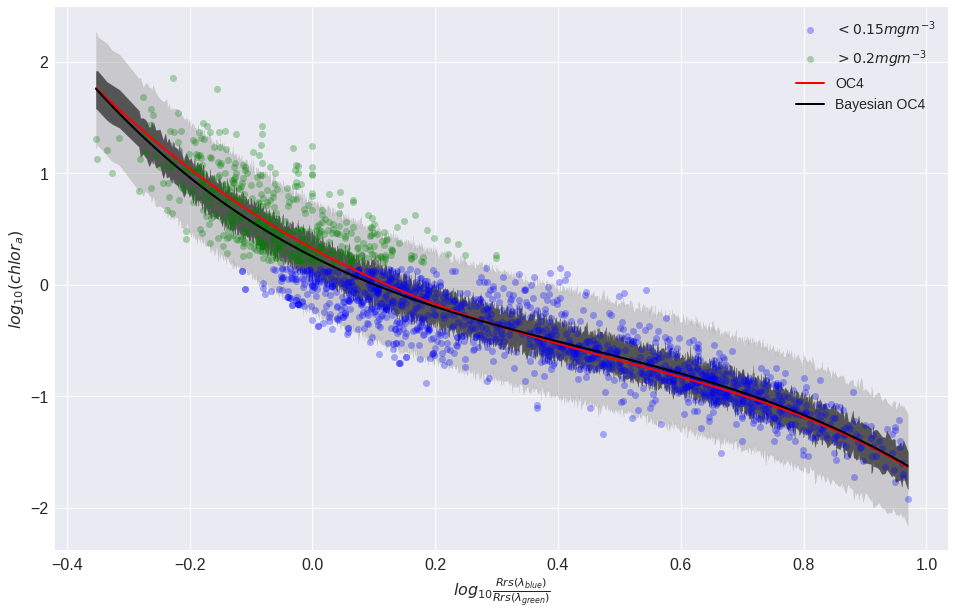

In [221]:
pl.figure(figsize=(16,10))
pl.fill_between(ocxRatio_ord, sig0[:,0], sig0[:,1], color='k', alpha=1)
pl.fill_between(ocxRatio_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5)
pl.plot(ocxRatio[chlObs<0.15],chlObs[chlObs<0.15],'bo',alpha=0.3, label='$<0.15mgm^{-3}$')
pl.plot(ocxRatio[chlObs>.2],chlObs[chlObs>.2],'go',alpha=0.3, label='$>0.2mgm^{-3}$')
pl.plot(ocxRatioMock,chlModl,'r', linewidth=2, label='OC4')
pl.plot(ocxRatioMock,chlBayes,'k', linewidth=2, label='Bayesian OC4')
pl.xlabel(r'$log_{10}\frac{Rrs\left(\lambda_{blue}\right)}{Rrs\left(\lambda_{green}\right)}$', fontsize=16)
pl.ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=16);
pl.legend(fontsize=14);

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()